<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>Tutorial 5: The Bootstrap</h2></center>
<br>

In this tutorial we will study how to use the bootstrap method to estimate sampling distributions in Python.

<a class="buttom" href="#Sampling-with-and-without-replacement">Sampling with and without replacement</a> <br>
<a class="buttom" href="#Dataset-1:-Portfolio-Returns">Dataset 1: Portfolio Returns</a> <br>
<a class="buttom" href="#Bootstrap-distribution">Bootstrap distribution</a> <br>
<a class="buttom" href="#Dataset-2:-Wage-Data">Dataset 2: Wage Data</a> <br>
<a class="buttom" href="#Bootstrapping-a-regression">Bootstrapping a regression</a> <br>
<a class="buttom" href="#Exercise">Exercise</a> <br>


This notebook relies on the following imports and settings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('notebook') 

We will plot histograms many times in this tutorial, so let's save a function to make the code more compact. 

In [2]:
def hist(series):
    fig, ax= plt.subplots()
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.9, 'edgecolor':'black', 'color': sns.color_palette('Blues')[-1]},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    return fig, ax

###Sampling with and without replacement

We start by illustrating the concepts of sampling with and without replacement, which we use in resampling methods.  

In [3]:
letters=['a','b','c','d','e','f','g','h']
print(letters)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']


Sampling without replacement means that we sample each element of the set at most once. One way to do is through permutations. 

In [4]:
sample = np.random.permutation(letters)
print(sample)

['e' 'h' 'd' 'c' 'a' 'f' 'g' 'b']


If we want say a sample of size three without replacement from the original set of letters, we can slice the sample to obtain it. 

In [5]:
print(sample[:3])

['e' 'h' 'd']


Of course, if we run the code again we get a different result. 

In [6]:
sample = np.random.permutation(letters)
print(sample)

['d' 'f' 'b' 'a' 'g' 'h' 'c' 'e']


To sample with replacement, we use the [<TT>randint</TT>](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html) function to generate random integers which are then our indexes for sampling an array.

The syntax belows generates a random integer between zero and four (that is, it selects 0, 1, 2, 3 or 4 with equal probability)

In [7]:
x = np.random.randint(5) 
print(x)

2


Specifying the size option allows us to repeat this process multiple times. Below, we have 10 random indexes.,

In [8]:
x = np.random.randint(5, size=10) 
print(x)

[0 3 3 3 4 1 2 4 2 0]


Later, our data will stored in arrays. Hence, we convert the list to an array here to see how the sampling process will work.

In [9]:
letters_array = np.array(letters)

Suppose that we want to sample 10 elements with replacement from the list of letters. The first step is to generate the random indexes. 

In [10]:
indexes = np.random.randint(len(letters), size=10) 
print(indexes)

[4 0 6 1 0 7 0 1 3 6]


We then use the indexes to collect the corresponding elements of the array.

In [11]:
sample = letters_array[indexes]
print(sample)

['e' 'a' 'g' 'b' 'a' 'h' 'a' 'b' 'd' 'g']


If we were just working with lists, we could use a list comprehension to obtain the sample. 

In [12]:
sample = [letters[i] for i in indexes]
print(sample)

['e', 'a', 'g', 'b', 'a', 'h', 'a', 'b', 'd', 'g']


###Dataset 1: Portfolio Returns

We start with a simple setting that involves bootstrapping the distribution of a sample average. In this dataset built from data collected from [Kenneth French's website](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html), we observe monthly returns of portfolios of stocks sorted according to their book-to-market ratios. Stocks with a high book-to-market ratio are called value stocks, in that they have good fundamentals relative to their market valuation. French's research (in collaboration with the Nobel laureate Eugene Fama) has documented that value stocks earn higher average returns than can be accounted for by their market betas, contradicting the Capital Asset Pricing Model (CAPM). 

Here, as an illustration of the bootstrap, our goal is to estimate the sampling distribution of the average returns of a portfolio of value stocks over a long period of time. This has important implications for investors, since this represents the distribution of the long run return of the portfolio.  According to the [Black Swan](https://www.amazon.com/Black-Swan-Improbable-Robustness-Fragility/dp/081297381X/) perspective, it is not obvious that this type of distribution is approximately Gaussian, since improbable outliers can have a disproportional impact even on a long run average. 

Unlike in the example in the lecture, we will see that the bootstrap confidence intervals agree with the formula interval in this case. 

Below, the high column indicates the returns of the portfolio of stocks with highest book-to-market ratio. 

In [13]:
data=pd.read_csv('FF-Book-to-Market.csv')
data.head()

,Date,MKT,RF,Low,Decile02,Decile03,Decile04,Decile05,Decile06,Decile07,Decile08,Decile09,High
0,31/1/1963,5.18,0.25,4.48,6.65,3.98,4.44,3.77,4.13,7.13,8.28,7.26,7.51
1,28/2/1963,-2.15,0.23,-3.67,-2.71,-1.19,-1.87,-2.00,-1.68,-1.48,-1.43,-0.16,-0.59
2,29/3/1963,3.31,0.23,2.52,4.96,3.01,2.41,3.49,4.38,3.09,5.28,4.23,4.30
3,30/4/1963,4.76,0.25,5.23,4.00,5.48,3.14,4.92,5.96,5.07,3.97,5.81,7.43
4,31/5/1963,2.00,0.24,2.40,4.06,-0.08,-0.06,2.95,1.21,3.63,2.88,2.33,7.25


In [14]:
len(data)

649

We start with some descriptive statistics, which show that the portfolio of value stocks has the highest average returns among the series in the dataset. All the portfolio returns have high monthly standard deviation, with the volatility of the portfolio of value stocks being the highest among all. 

In [15]:
data.describe().iloc[[1,2,3,-1],:].round(2)

,MKT,RF,Low,Decile02,Decile03,Decile04,Decile05,Decile06,Decile07,Decile08,Decile09,High
mean,0.91,0.39,0.82,0.94,0.98,0.93,0.94,1.07,1.03,1.11,1.27,1.33
std,4.40,0.26,5.02,4.61,4.56,4.61,4.41,4.33,4.56,4.62,4.93,6.08
min,-22.64,0.00,-22.75,-24.81,-25.72,-23.58,-23.56,-22.98,-24.49,-24.68,-19.03,-25.84
max,16.61,1.35,23.02,19.52,16.98,18.06,17.44,18.39,22.20,22.64,22.46,33.58


Plotting the distribution of the value portfolio and market returns shows that they have fat tails: there are a higher number of extreme returns, both positive and negative, than we would expect under the normal distribution. This is not surprising for return data, but are these outliers large enough to affect the shape of the sampling distribution of the average? 

The market returns display some negative sample skewness.

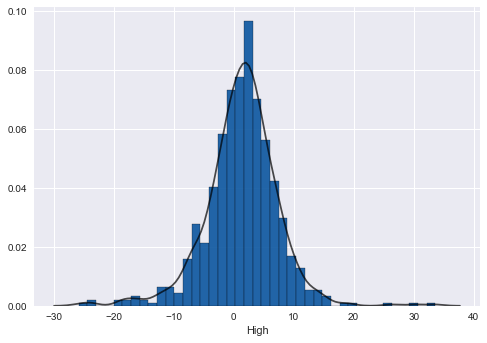

In [16]:
hist(data['High'])
plt.show()

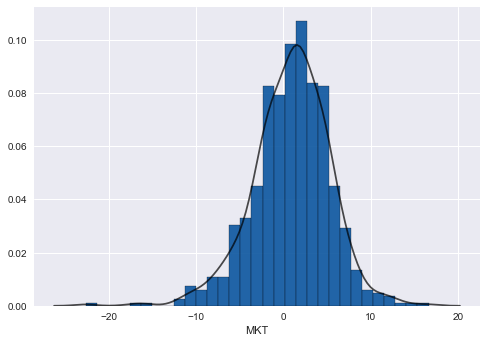

In [17]:
hist(data['MKT'])
plt.show()

For the analysis, I convert the returns to [log returns](https://quantivity.wordpress.com/2011/02/21/why-log-returns/) since unlike raw returns, it makes sense to average them. When referring to returns below, I mean log returns. Percentage numbers are approximate.  

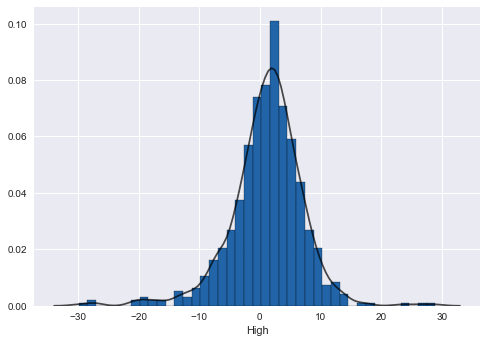

In [18]:
x = 100*np.log(1+data['High']/100)
hist(x)
plt.show()

The portfolio of value stocks has average monthly returns of 1.13%.

In [19]:
x_mean = x.mean()
print(round(x_mean,3))

1.134


Considering the high volatility of the portfolio, interval estimation is arguably more interesting for this problem. Below, we compute the large sample interval based on the t distribution. The 99% confidence interval is very wide in practical terms, ranging from 0.52% to 1.75%. 

In [20]:
from scipy import stats 

se = np.std(x, ddof=1)/np.sqrt(len(x))
ci_low = x_mean - se*stats.t.ppf(0.995, df=len(x)-1)
ci_high = x_mean + se*stats.t.ppf(0.995, df=len(x)-1)
           
print(round(ci_low, 3))
print(round(ci_high, 3))

0.516
1.752


In this interval accurate? Are 649 observations sufficient for a large sample approximation to hold, in light on the possible outliers in the histogram? With bootstrapping, we can check. 

###Bootstrap confidence intervals

The next cell shows how to compute a boostrap distribution for the sample average. We use the tools that we learned in the first part of the tutorial to sample with replacement from the data.

Below, I also add a command to measure how long the cell takes to run. This is very important as the computational cost is a concern with the bootstrap method. You should start with a trial run of only a few replications to get an idea of how long it may take to run the same cells with thousands of replications (not a problem in this case).

In [21]:
%%time

# Settings
S = 10000 # Number of bootstrap replications (start small!)
n = len(x) # It is useful to store the size of the data

# Generating the bootstrap samples
# The bootstrap sample has the same size as the original sample

mean_boot=[]
for i in range(S):
    x_boot = x.iloc[np.random.randint(n, size=n)] # draws a sample of size n from x with replacement
    mean_boot.append(x_boot.mean()) # adds the mean of the bootstrap sample

Wall time: 839 ms


The histogram below shows that the bootstrap distribution is very close to normal. Because the bootstrap distribution approximates the shape and spread of the actual sampling distribution, we can say that the normal approximation suggested by the large sample theory is accurate in this case. Unlike in basic statistics, however, we are now actually checking this.  

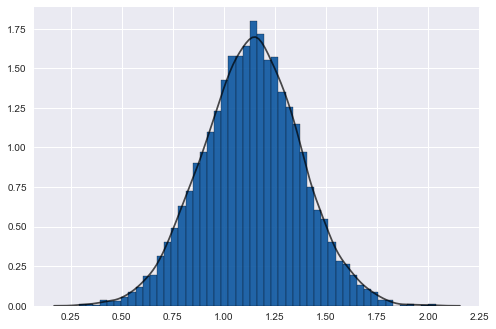

In [22]:
hist(mean_boot)
plt.show()

The bootstrap percentile interval agrees with the formula interval from above. 

In [23]:
ci_low = np.percentile(mean_boot, 0.5)
ci_high = np.percentile(mean_boot, 99.5)

print(round(ci_low, 3))
print(round(ci_high, 3))

0.516
1.741


In the lecture, we discussed that the bootstrap t interval tends to be the most accurate of all intervals that we have seen so far, including the formula intervals. The bootstrap t interval applies to cases in which we have a reliable formula for the standard error. The next two cells go through the process.

As before, the nature of the current problem is such that the bootstrap t interval will agree with the others in this case. 

In [24]:
%%time

# Settings
S = 10000 # Number of bootstrap replications (start small!)
n = len(x) # It is useful to store the size of the data

# Generating the bootstrap samples

tboot=[]
for i in range(S):
    x_boot = x.iloc[np.random.randint(n, size=n)] # draws a sample of size n from x with replacement
    se_boot = np.std(x_boot, ddof=1)/np.sqrt(n)
    tboot.append((x_boot.mean()-x_mean)/se_boot) 

Wall time: 1.26 s


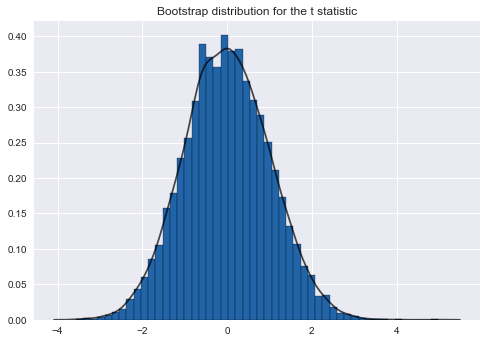

In [25]:
fig, ax = hist(tboot)
ax.set_title('Bootstrap distribution for the t statistic')
plt.show()

In [26]:
ci_low = x_mean-se*np.percentile(tboot, 99.5)
ci_high = x_mean-se*np.percentile(tboot, 0.5)

print(round(ci_low, 3))
print(round(ci_high, 3))

0.522
1.725


A word of caution about this analysis: the returns uncorrelated, but not independent over time. In particular, the variance of returns changes over time, and tends to display time clustering (you can easily see this below).  In contrast, the standard bootstrap assumes independent sample. Hence, our results suffers from limitations that we would need to address with time series methods that are outside the scope of this unit. 

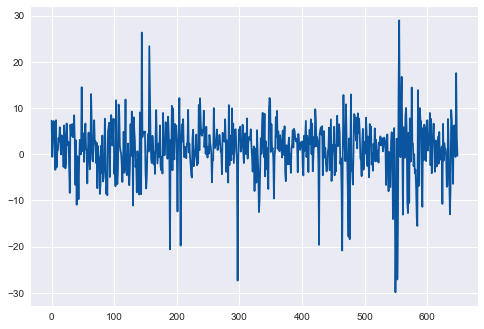

In [27]:
plt.plot(x, color=sns.color_palette('Blues')[-1])
plt.show()

###Dataset 2: Wage Data

We now consider a regression problem using the wage data from the ISL textbook. 

In [28]:
train=pd.read_csv('Wage.csv')
train.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [29]:
len(train)

3000

Our interest is in the relationship between age and salary, which follows a nonlinear pattern. 

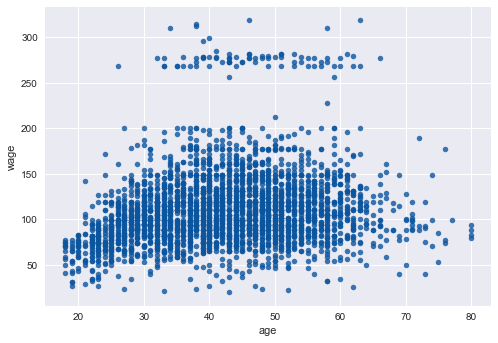

In [30]:
blue = sns.color_palette('Blues')[-1]
sns.regplot(train['age'], train['wage'], scatter_kws={'s': 30},fit_reg=False, color=blue)
sns.despine()
plt.show()

In light of the nonlinearity in this relationship, one option is to use a polynomial regression. We start with model selection based on the AIC to choose the number of polynomial terms. We select a polynomial of order 4.  

In [31]:
import statsmodels.formula.api as smf
formula='wage ~ age'
ols = smf.ols(formula=formula, data=train).fit()
ols.aic

30786.674044427171

In [32]:
formula='wage ~ age + np.power(age, 2)'
ols = smf.ols(formula=formula, data=train).fit()
ols.aic

30648.798920344783

In [33]:
formula='wage ~ age + np.power(age, 2) + np.power(age, 3)'
ols = smf.ols(formula=formula, data=train).fit()
ols.aic

30640.921873508745

In [34]:
formula='wage ~ age + np.power(age, 2) + np.power(age, 3) + np.power(age, 4)'
ols = smf.ols(formula=formula, data=train).fit()
ols.aic

30639.107876767703

The distribution of the residuals has an unusual bimodal shape, reflecting the cluster of individuals with high wage that we can seen on the scatter plot above. 

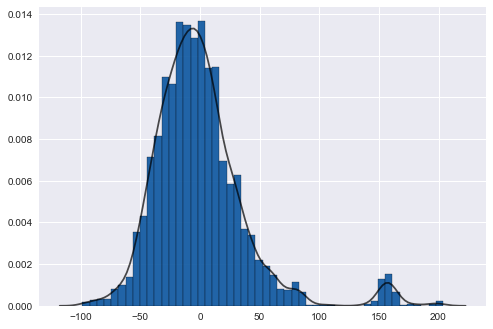

In [35]:
hist(ols.resid)
plt.show()

The assumption of constant error variance is not satisfied due to the high wage observations.

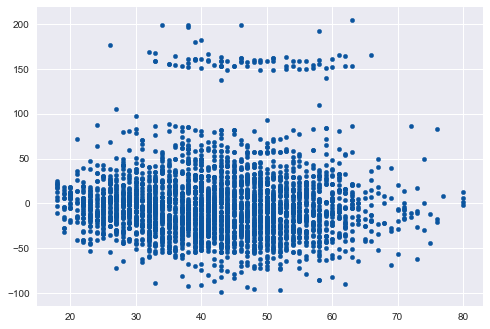

In [36]:
plt.scatter(train['age'], ols.resid, color=blue, s=20)
plt.show()

We now plot the estimated regression function. 

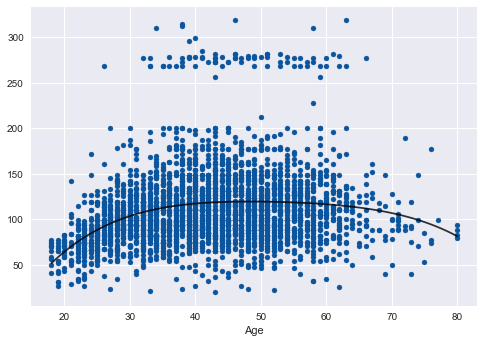

In [37]:
# Grid of age values
x = np.linspace(train['age'].min(), train['age'].max(), 100)
x = pd.DataFrame(x, columns = ['age']) # we need to label this data as age for the regression object to recognise it

# Compute the predicted values for each of these input points
predictions = ols.predict(x)

# Figure
fig, ax = plt.subplots()
ax.scatter(train['age'], train['wage'], color=blue, s=25) # the s option is the size of the dot
ax.set_xlabel('Age')
ax.plot(x, predictions, color='black', alpha = 0.8)
plt.show()

###Bootstrapping a regression

How accurate is the estimate of the polynomial regression function? We generate bootstrap samples of the data to answer this question.

The figure shows that the estimates for older individuals can vary substantially depending on the sample. 

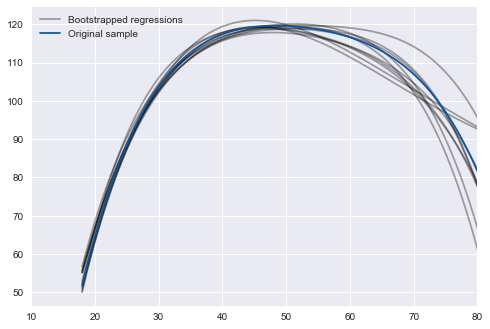

Wall time: 283 ms


In [38]:
%%time

# Settings
S = 10 # Number of bootstrap replications (start small!)
n = len(train) # It is useful to store the size of the data

# Generating the bootstrap samples

fig, ax = plt.subplots()


for i in range(S):
    train_boot= train[['age','wage']].iloc[np.random.randint(n, size=n),:] # draws a sample of size n from train with replacement
    ols_boot = smf.ols(formula=formula, data=train_boot).fit()
    predictions_boot = ols_boot.predict(x) 
    if i == 0: # we only want to add one legend label for the bootstrap samples
        ax.plot(x, predictions_boot, color='black', alpha = 0.35, label='Bootstrapped regressions')
    else:
        ax.plot(x, predictions_boot, color='black', alpha = 0.35)

    
ax.plot(x, predictions, color=blue, label='Original sample')
ax.set_xlim(10,80)
plt.legend(loc='best')
plt.show()

A note here: strictly speaking, we should bootstrap the entire algorithm, which includes model selection. In some bootstrap samples, we may end up choosing say three polynomial terms rather than four. We ignore this here for simplicity. 

Now, we use bootstrapping to compute and plot a confidence interval for the entire regression fit. We start by generating the bootstrap samples and predictions for each of them. The next cell may take a while to run, so be careful with the number of replications. Start small to test. 

In [39]:
%%time 

# Settings
S = 10000 # Number of bootstrap replications (start small!)
n = len(train) # It is useful to store the size of the data

predictions_boot  = []
for i in range(S):
    train_boot= train[['age','wage']].iloc[np.random.randint(n, size=n),:] # draws a sample of size n from train with replacement
    ols_boot = smf.ols(formula=formula, data=train_boot).fit()
    predictions_boot.append(ols_boot.predict(x)) 

Wall time: 1min 59s


We need additional code to retrieve the endpoints of the interval.

In [40]:
low = []
high = []

for i in range(len(x)):
    # Tutors: please carefully explain the next line
    boot_sample = [y[i] for y in predictions_boot] # retrieving the i-th fitted value for all the boostrap samples
    low.append(np.percentile(boot_sample, 2.5))
    high.append(np.percentile(boot_sample, 97.5))

Finally, we can plot the confidence interval. 

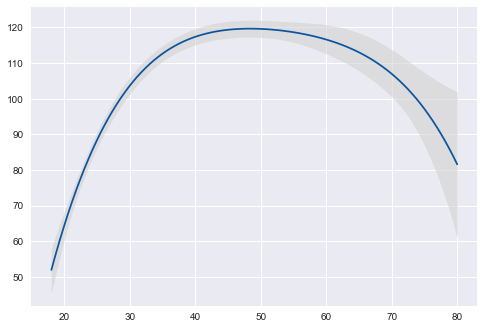

In [53]:
fig, ax = plt.subplots()  
ax.plot(x, predictions, color=blue)
ax.fill_between(np.ravel(x), low, high, color='#D3D3D3', alpha=0.6) 
# the np.ravel is a technical detail, we need to flatten the array
plt.show()

###Exercise

**Problem 1.** Adapt the code above and use the recipe from the lecture to plot a confidence interval for the regression function by bootstrapping the residuals instead.

**Problem 2.** The next cell shows how to obtain standard prediction intervals. They do not make sense: the lower end points are negative wages. This is because the prediction interval is based on the assumption of normality of the residuals, among other problems.  

Construct a plot a prediction interval for the entire age range based on the empirical distribution of the residuals, ignoring the reducible error for now. Are the intervals more reasonable in this case? Are there any problems with the assumptions?  Note that a prediction interval is not the same as an interval for the regression function as above.

**Problem 3.**  This part is more challenging and optional. Use bootstrapping and the empirical distribution of the residuals 
 to obtain a prediction interval for the entire age range. Do this by sampling from 

In [56]:
pred=ols.get_prediction(x).summary_frame().round(2)
pred.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,51.93,5.30,41.54,62.32,-27.02,130.88
1,56.10,4.70,46.89,65.32,-22.70,134.91
2,60.08,4.16,51.92,68.23,-18.61,138.76
3,63.86,3.68,56.65,71.07,-14.73,142.46
4,67.46,3.25,61.08,73.84,-11.06,145.98
